In [1]:
# LOAD PACKAGES
from scipy.spatial.transform import Rotation as R
import numpy as np
import plotly.graph_objects as go
import pandas as pd
import matplotlib.pyplot as plt
import math
import warnings; warnings.simplefilter('ignore')
from matplotlib.lines import Line2D
from scipy.signal import butter, filtfilt
from scipy.optimize import differential_evolution
from scipy.optimize import minimize
from scipy.signal import sosfilt
from scipy.ndimage import median_filter
plt.rcParams['figure.dpi'] = 150

/Users/rhemitoth/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# LOAD THE DATA
df1_raw = pd.read_table('/Users/rhemitoth/Documents/PhD/Cembra/Dead_Reckoning/Data/Gundog_Tutorial/L1_continuous_export_split#3.txt.txt')
df2_raw = pd.read_table('/Users/rhemitoth/Documents/PhD/Cembra/Dead_Reckoning/Data/Gundog_Tutorial/L1_continuous_export_split#4.txt.txt')
df3_raw = pd.read_table('/Users/rhemitoth/Documents/PhD/Cembra/Dead_Reckoning/Data/Gundog_Tutorial/L1_continuous_export_split#5.txt.txt')
gps = pd.read_csv('/Users/rhemitoth/Documents/PhD/Cembra/Dead_Reckoning/Data/Gundog_Tutorial/L1.GPS.UTM.csv')

In [3]:
# Merge ACC datasets
df_raw = pd.concat([df1_raw, df2_raw], ignore_index=True)
df_raw = pd.concat([df_raw,df3_raw],ignore_index=True)

In [4]:
# Convert timestamp from string to datetime
df_raw['datetime_txt'] = df_raw['Date'] + " " + df_raw['Time hh:mm:ss.ddd']
df_raw['datetime'] = pd.to_datetime(df_raw['datetime_txt'], format = '%d/%m/%Y %H:%M:%S.%f')

gps['datetime_txt'] = gps['Date'] + " " + gps['Time']
gps['datetime'] = pd.to_datetime(gps['datetime_txt'], format = '%d/%m/%Y %H:%M:%S')

In [5]:
# Select Columns
df_raw = df_raw[['Acc_x',
        'Acc_y',
        'Acc_z',
        'Mag_x',
        'Mag_y',
        'Mag_z',
        'datetime']]

In [6]:
# Merge GPS and activity data
df_raw = pd.merge(df_raw, gps, on='datetime', how='left')

In [7]:
df_raw['datetime'].max()

Timestamp('2019-02-28 13:13:38')

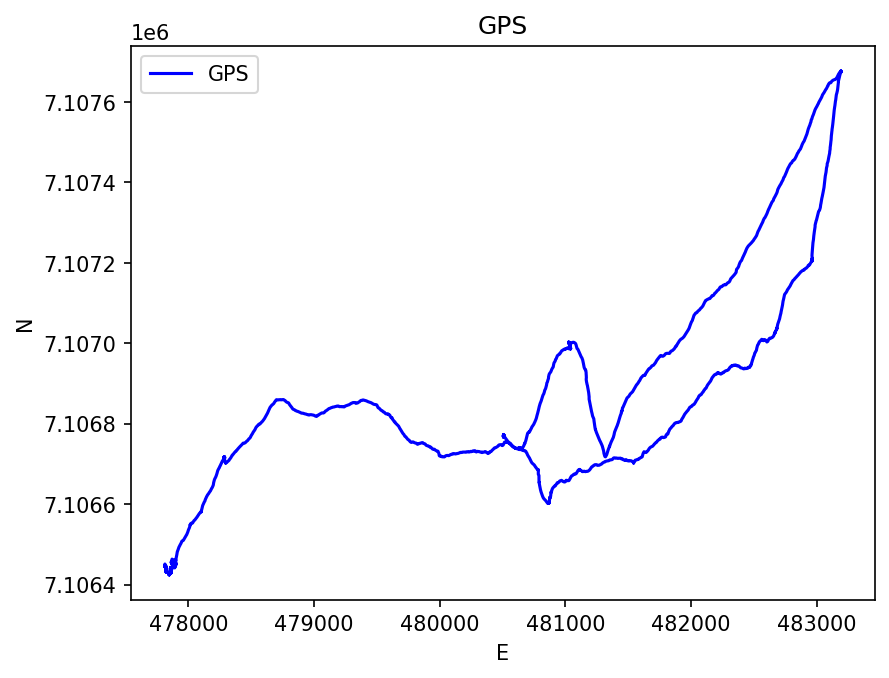

In [8]:
# PLOT GPS OVER TIME
# Calculate distance traveled during GPS track using the euclidean distance formula on each step
start_time = '2019-02-26 03:00:00'
end_time = '2019-02-26 09:00:00'

gps_pts = df_raw.copy()[(df_raw['datetime'] >= start_time) & (df_raw['datetime'] <= end_time)][df_raw['UTM_E'].notnull()]

x = gps_pts['UTM_E']
y = gps_pts['UTM_N']

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111)

# Plot the trajectory
ax.plot(x, y,  color='b', label='GPS')

# Setting labels
ax.set_xlabel('E')
ax.set_ylabel('N')

# Adding a title and legend
ax.set_title('GPS')
ax.legend()

# Show plot
plt.show()

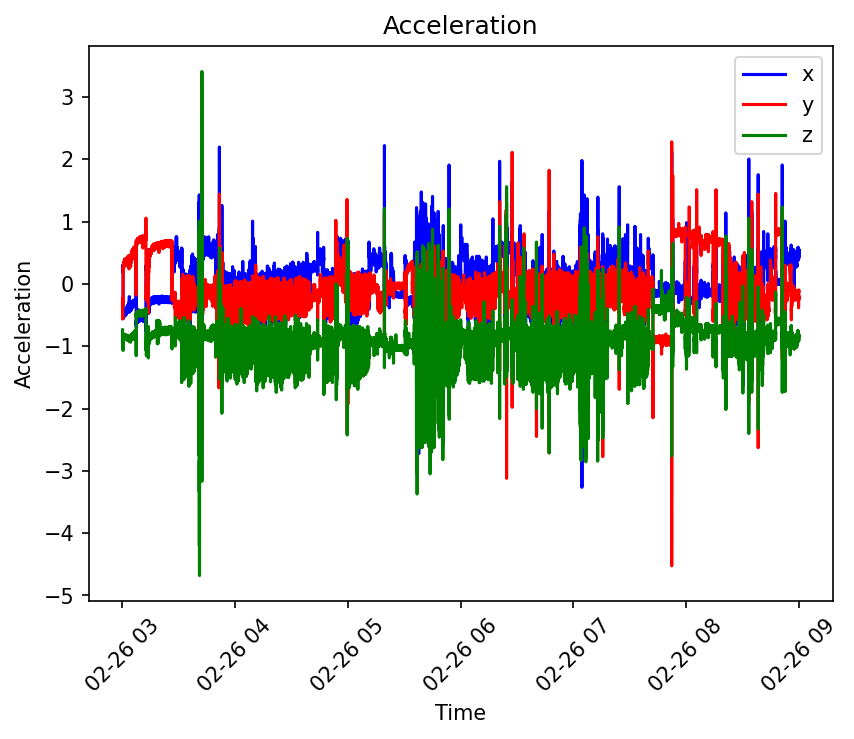

In [9]:
df = df_raw.copy()[(df_raw['datetime'] >= start_time) & (df_raw['datetime'] <= end_time)].reset_index()

# PLOT ACCELERATION OVER TIME
Acc_x = df['Acc_x']
Acc_y = df['Acc_y']
Acc_z = df['Acc_z']
dt = df['datetime']

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111)

# Plot the trajectory
ax.plot(dt, Acc_x, linestyle='-', color='b', label='x')
ax.plot(dt, Acc_y,  linestyle='-', color='r', label='y')
ax.plot(dt, Acc_z,  linestyle='-', color='g', label='z')

# Setting labels
ax.set_xlabel('Time')
ax.set_ylabel('Acceleration')

# Rotate the x axis labels
plt.xticks(rotation = 45)

# Adding a title and legend
ax.set_title('Acceleration')
ax.legend()

# Show plot
plt.show()

## 1) Remove effects of pitch and roll

Static acceleration is estimated using a 4th order zero phase low pass butterworth filter with wc = 0.1 Hz following Ladha et al. 2018 (BMC Veterinary Research). 

In [10]:
# DESIGN THE BUTTERWORTH FILTER

# Parameters
order = 4  # 4th order
cutoff_frequency = 0.1  # Cutoff frequency in Hz
sampling_rate = 1  # Sampling rate in Hz (adjust as needed)

# Normalized cutoff frequency (as a fraction of the Nyquist frequency)
nyquist_frequency = 0.5 * sampling_rate
normalized_cutoff = cutoff_frequency / nyquist_frequency

# Get the filter coefficients
b, a = butter(order, normalized_cutoff, btype='low', analog=False)

In [11]:
# APPLY THE FILTER TO CALCULATE STATIC ACCELERATION

df['Gx'] = filtfilt(b, a, df['Acc_x'])
df['Gy'] = filtfilt(b, a, df['Acc_y'])
df['Gz'] = filtfilt(b, a, df['Acc_z'])

# Calculate Dynamic Acceleration
df['DAx'] = df['Acc_x'] - df['Gx']
df['DAy'] = df['Acc_y'] - df['Gy']
df['DAz'] = df['Acc_z'] - df['Gz']

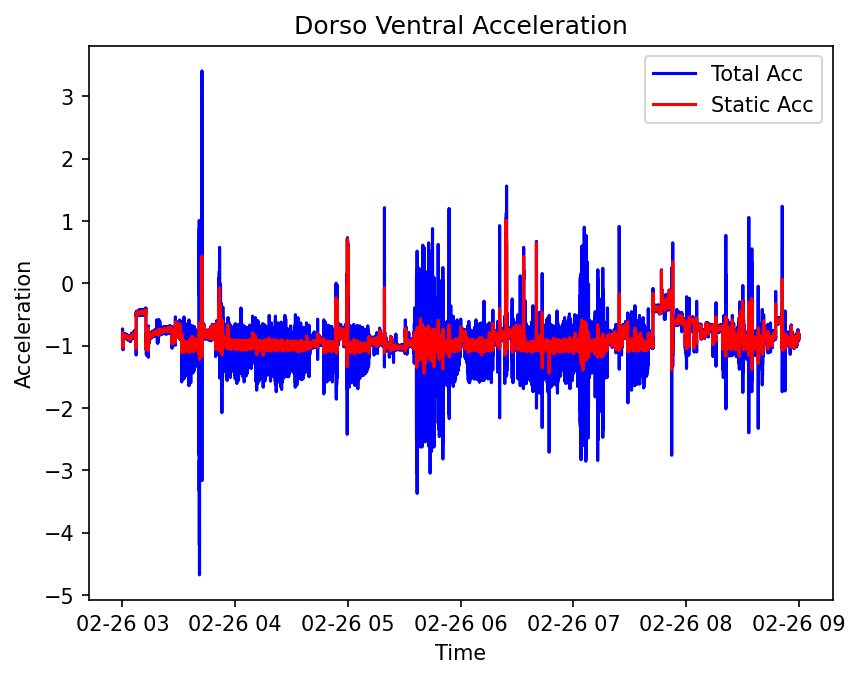

In [12]:
# PLOT STATIC ACCLERATION
Acc_z = df['Acc_z']
Gz = df['Gz']
dt = df['datetime']

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111)

# Plot the trajectory
ax.plot(dt, Acc_z,  linestyle='-', color='b', label='Total Acc')
ax.plot(dt, Gz,  linestyle='-', color='r', label='Static Acc')

# Setting labels
ax.set_xlabel('Time')
ax.set_ylabel('Acceleration')

# Adding a title and legend
ax.set_title('Dorso Ventral Acceleration')
ax.legend()

# Show plot
plt.show()

In [13]:
# Get static acceleration
Gx = np.array(df['Gx'])
Gy = np.array(df['Gy'])
Gz = np.array(df['Gz'])

# Compute pitch (radians)
pitch = np.arctan2(Gy,np.sqrt(Gx**2 + Gz**2))
df['pitch'] = pitch

# Compute roll (radians)
roll =  np.arctan2(Gx,np.sqrt(Gy**2 + Gz**2))
df['roll'] = roll

In [14]:
# Get Rx
def get_Rx(pitch_values):
    cos_pitch = np.cos(pitch_values)
    sin_pitch = np.sin(pitch_values)

    # Create an empty array to hold the rotation matrices
    # Shape: (n, 3, 3) where n is the number of pitch values
    rotation_matrices = np.zeros((pitch_values.shape[0], 3, 3))

    # Fill in the rotation matrices
    rotation_matrices[:, 0, 0] = 1  # First row, first column is always 1
    rotation_matrices[:, 1, 1] = cos_pitch  # cos(pitch) in second row, second column
    rotation_matrices[:, 1, 2] = sin_pitch  # sin(pitch) in second row, third column
    rotation_matrices[:, 2, 1] = -sin_pitch # -sin(pitch) in third row, second column
    rotation_matrices[:, 2, 2] = cos_pitch  # cos(pitch) in third row, third column

    return rotation_matrices

Rx = get_Rx(pitch)

# Get Ry
def get_Ry(roll_values):
    cos_roll = np.cos(roll_values)
    sin_roll = np.sin(roll_values)

    # Create an empty array to hold the rotation matrices
    # Shape: (n, 3, 3) where n is the number of roll values
    rotation_matrices = np.zeros((roll_values.shape[0], 3, 3))

    # Fill in the rotation matrices
    rotation_matrices[:, 0, 0] = cos_roll  # cos(roll) in first row, first column
    rotation_matrices[:, 0, 2] = sin_roll  # sin(roll) in first row, third column
    rotation_matrices[:, 1, 1] = 1         # 1 in the second row, second column
    rotation_matrices[:, 2, 0] = -sin_roll # -sin(roll) in third row, first column
    rotation_matrices[:, 2, 2] = cos_roll  # cos(roll) in third row, third column

    return rotation_matrices

Ry = get_Ry(roll)

# Get array of raw acceleration
Acc = np.asarray(df[['Acc_x','Acc_y','Acc_z']])

# Compute combined rotation matrices
combined_rotation_matrices = np.einsum('ijk,ikl->ijl', Rx, Ry)

# Apply the combined rotation matrices to the vectors
rotated_data = np.einsum('ijk,ik->ij', combined_rotation_matrices, Acc)
rotated_data_df = pd.DataFrame(rotated_data, columns=['RAx', 'RAy', 'RAz'])
df['RAx'] = rotated_data_df['RAx']
df['RAy'] = rotated_data_df['RAy']
df['RAz'] = rotated_data_df['RAz']


In [15]:
# # ROTATE DATA

# # Build rotation function
# def rotate_data(row):
#     pitch = row['pitch']
#     roll = row['roll']
#     Rx = np.array([[1,0,0],
#           [0,math.cos(pitch),math.sin(pitch)],
#           [0,-math.sin(pitch),math.cos(pitch)]])
#     Ry = np.array([[math.cos(roll),0,-math.sin(roll)],
#          [0,1,0],
#          [math.sin(roll),0,math.cos(roll)]])
#     Ax = row['Acc_x']
#     Ay = row['Acc_y']
#     Az = row['Acc_z']
#     A = np.array([[Ax],[Ay],[Az]])
#     RA = Ry @ Rx @ A
#     row['RAx'] = RA[0]
#     row['RAy'] = RA[1]
#     row['RAz'] = RA[2]
#     return row

# # Initialize columns
# df['RAx'] = -999
# df['RAy'] = -999
# df['RAz'] = -999

# # Rotate data
# df = df.apply(rotate_data,axis=1)

## Identify movement periods using magnitude threshold

In [16]:
# DESIGN THE BUTTERWORTH FILTER

# Parameters
order = 4  # 4th order
cutoff_frequency = 0.2  # Cutoff frequency in Hz
sampling_rate = 1  # Sampling rate in Hz (adjust as needed)

# Normalized cutoff frequency (as a fraction of the Nyquist frequency)
nyquist_frequency = 0.5 * sampling_rate
normalized_cutoff = cutoff_frequency / nyquist_frequency

# Get the filter coefficients
b, a = butter(order, normalized_cutoff, btype='low', analog=False)

In [17]:
# APPLY THE FILTER TO ROTATED DATA
df['FRAx'] = filtfilt(b, a, df['RAx'])
df['FRAy'] = filtfilt(b, a, df['RAy'])
df['FRAz'] = filtfilt(b, a, df['RAz'])

In [18]:
# Compute magnitude of acceleration vector
df['FRAx'] = pd.to_numeric(df['FRAx'], errors='coerce')
df['FRAy'] = pd.to_numeric(df['FRAy'], errors='coerce')
df['FRAz'] = pd.to_numeric(df['FRAz'], errors='coerce')
df['magnitude'] = np.sqrt(df['FRAx']**2 + df['FRAy']**2 + df['FRAz']**2)

# Define a threshold for classifying activity based on standard deviation
sd_threshold = 0.01 # standard deviation

# Calculate standard deviation of magnitude of acceleration using a rolling window
window_size = 50 # 5 Seconds
df['mag_sd'] = df['magnitude'].rolling(window=window_size).std()

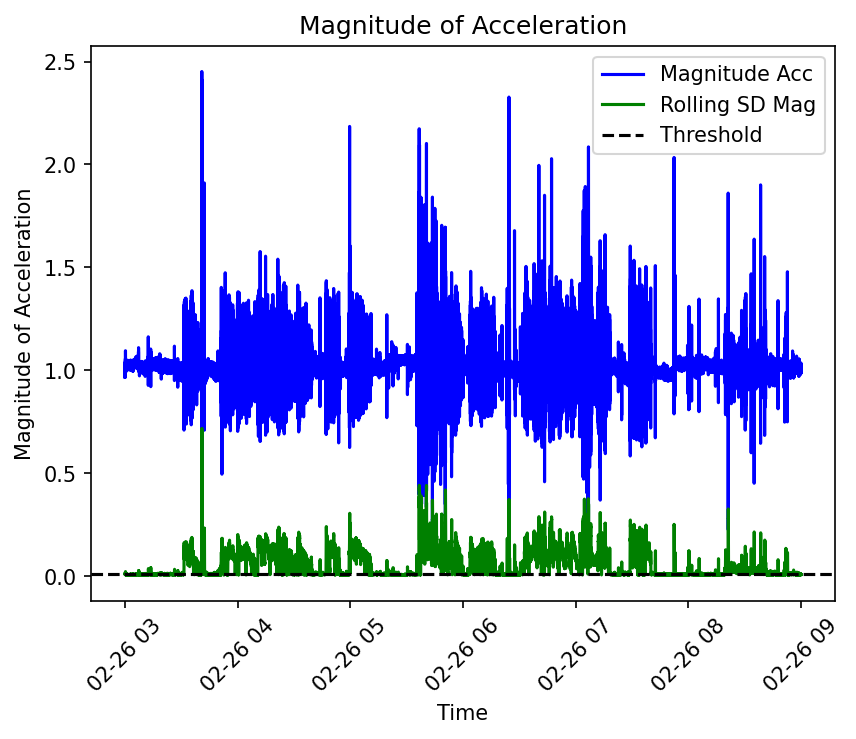

In [19]:
# Plot magnitude vs time
mag = df['magnitude']
dt = df['datetime']
mag_std = df['mag_sd']

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111)

# Plot the trajectory
ax.plot(dt, mag, linestyle='-', color='b', label='Magnitude Acc')
ax.plot(dt,mag_std,linestyle="-", color = "g", label = "Rolling SD Mag")
plt.axhline(y=sd_threshold, color='black', linestyle='--', label='Threshold')

# Setting labels
ax.set_xlabel('Time')
ax.set_ylabel('Magnitude of Acceleration')

# Rotate the x axis labels
plt.xticks(rotation = 45)

# Adding a title and legend
ax.set_title('Magnitude of Acceleration')
ax.legend()

# Show plot
plt.show()

In [20]:
# Split activity periods into groups based on SD threshold
above_sd_threshold = np.array(df['mag_sd']) > sd_threshold
sd_threshold_change = np.append([False],above_sd_threshold[:-1] != above_sd_threshold[1:])
activity_group = np.cumsum(sd_threshold_change)
df['activity_group'] = activity_group

# Assign activity status based on SD threshold
df['active'] = above_sd_threshold

# Get rid of small groups (activity periods < 20s)
group_counts = df.groupby('activity_group').size().reset_index(name='Count')
small_groups = group_counts.loc[group_counts['Count']<=200,'activity_group'].values
df.loc[df['activity_group'].isin(small_groups), 'active'] = 0

In [21]:
active_periods = df.copy()[df['active']==1].reset_index()

## Identify candidate steps using dynamic threshold on filtered DV axis

In [22]:
# Set the timestamp as the index
active_periods.set_index('datetime', drop = False, inplace = True) 

# Initialize zero threshold column
active_periods['thresh_z'] = -999

# Initialize falling flank column
active_periods['falling_edges'] = False

In [23]:
# Get a list of activity groups

activity_groups = active_periods.loc[active_periods['active']==1,'activity_group'].unique()
num_groups = len(activity_groups)

# Derive zero threshold for each activity group using 20s windows

for i in range(0,num_groups):
    
    # get group number
    group = activity_groups[i]
    
    # get group data
    group_data = active_periods[active_periods['activity_group'] == group]
    
    # calculate zero threshold
    for window_start in group_data.resample('20S').groups:
    
        window_data = group_data.loc[window_start:window_start + pd.Timedelta(seconds=20)]
    
        # Identify mean of max peak and min nadir in each window for acc in z axis
        signal = window_data['FRAz'].values
        max_z = signal.max()
        min_z = signal.min()
        thresh = (max_z + min_z)/2
        window_data['thresh_z'] = thresh
    
        # Identify falling flanks that cross the zero threshold 
        
        falling_edges = (signal[:-1] > thresh) & (signal[1:] <= thresh)
        window_data['falling_edges'].iloc[1:] = falling_edges
    
        group_data.loc[window_start:window_start + pd.Timedelta(seconds=20)] = window_data

    # Join group data back to complete dataset
    active_periods[active_periods['activity_group'] == group] = group_data
    

In [24]:
# # DERIVE ZERO THRESHOLD USIng 20s WINDOWS

# # Set the timestamp as the index
# df.set_index('datetime', drop = False, inplace = True) 

# # Initialize zero threshold column
# df['thresh_z'] = -999

# # Initialize falling flank column
# df['falling_edges'] = False

# for window_start in df.resample('20S').groups:

#     window_data = df.loc[window_start:window_start + pd.Timedelta(seconds=20)]

#     # Identify mean of max peak and min nadir in each window for acc in z axis
#     signal = window_data['FRAz'].values
#     max_z = signal.max()
#     min_z = signal.min()
#     thresh = (max_z + min_z)/2
#     window_data['thresh_z'] = thresh

#     # Identify falling flanks that cross the zero threshold 
    
#     falling_edges = (signal[:-1] > thresh) & (signal[1:] <= thresh)
#     window_data['falling_edges'].iloc[1:] = falling_edges

#     df.loc[window_start:window_start + pd.Timedelta(seconds=20)] = window_data
    

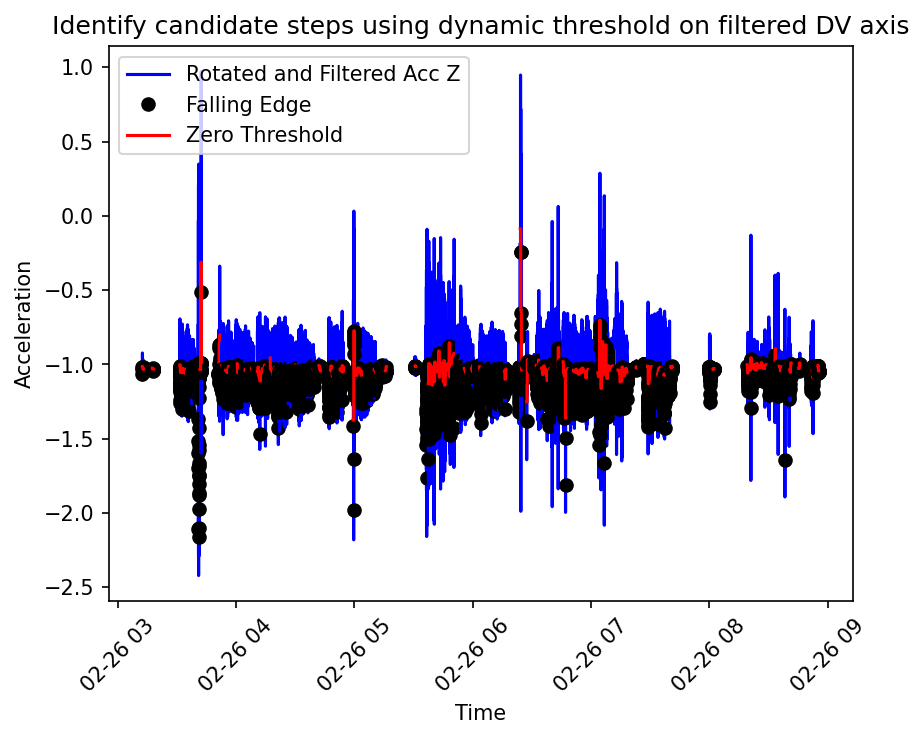

In [25]:
# Create plot
fig = plt.figure()
ax = fig.add_subplot(111)

# Add data by group
for i in range(0,num_groups):

    # get group number
    group = activity_groups[i]
    
    # get group data
    group_data = active_periods[active_periods['activity_group'] == group]
    
    # Get data for plotting
    FRAz = group_data['FRAz']
    thresh_z = group_data['thresh_z']
    dt = group_data['datetime']
    dt_falling_edges = group_data[active_periods['falling_edges'] == True]['datetime']
    falling_edges = group_data[active_periods['falling_edges'] == True]['FRAz']

    # Plot the data
    ax.plot(dt, FRAz, linestyle='-', color='b', label='Rotated and Filtered Acc Z')
    ax.plot(dt_falling_edges, falling_edges, marker = "o",linestyle='', color='black', label='Falling Edge')
    ax.plot(dt, thresh_z,  linestyle='-', color='r', label='Zero Threshold')

    # Add legend
    if i == 0:
        ax.legend()

# Rotate the x axis labels
plt.xticks(rotation = 45)

# Setting labels
ax.set_xlabel('Time')
ax.set_ylabel('Acceleration')

# Adding a title and legend
ax.set_title('Identify candidate steps using dynamic threshold on filtered DV axis')

# Show plot
plt.show()


## Filter steps based on valid step frequencies

In [26]:
# VALID STEP FREQUENCIES
# Based on range of observed stride frequencies in Eland (a species of comparable body mass; stride frequency is known to scale w body mass)
min_stride_freq = 0.5
max_stride_freq = 2
min_period = 1/max_stride_freq
max_period = 1/min_stride_freq

In [27]:
# Initialize dataframe to store step candidates
cols = list(df.columns) + ['elapsed_time'] 
step_candidates = pd.DataFrame(columns=cols)


# Get step candidates from each activity period and append them to the step_candidates dataframe
for i in range(0,num_groups):
    
    # get group number
    group = activity_groups[i]
    
    # get group data
    group_data = active_periods[active_periods['activity_group'] == group]

    # Filter group data for step candidates
    step_candidates_by_group = group_data[group_data['falling_edges'] == True]

    # Compute time between candidates
    step_candidates_by_group['elapsed_time'] = step_candidates_by_group['datetime'].diff().apply(lambda x: x.total_seconds()) 

    # Populate 'activity_group' column of step_candidates dataframe
    step_candidates_by_group['activity_group'] = group

    # Join step candidates from each group to main step candidates table
    step_candidates = pd.concat([step_candidates,step_candidates_by_group],ignore_index=True)

In [28]:
# Reset indices of step_candidates and df
active_periods['rowID'] = range(0,len(active_periods))
step_candidates['rowID'] = range(0,len(step_candidates))
active_periods.set_index('rowID', inplace = True) 
step_candidates.set_index('rowID', inplace = True) 

In [29]:
# Filter out false steps based on range of valid step frequencies
obs_freq = np.array(step_candidates['elapsed_time'])
valid_steps = (obs_freq >= min_period) & (obs_freq<= max_period)
step_candidates['valid_step'] = valid_steps
step_candidates = step_candidates[['valid_step','datetime','activity_group']]
step_candidates = step_candidates[step_candidates['valid_step'] == True].reset_index()

In [30]:
# Join step candidates back to original df
active_periods = pd.merge(step_candidates[['valid_step','datetime']],active_periods,on = 'datetime', how='right')

## Estimate distance traveled

In [31]:
# Distance traveled from GPS

# Define start and end pts of each step
x0 = gps_pts['UTM_E'].iloc[:-1].values
x1 = gps_pts['UTM_E'].iloc[1:].values
y0 = gps_pts['UTM_N'].iloc[:-1].values
y1 = gps_pts['UTM_N'].iloc[1:].values

# Calculate x1-x0 and y1-y0
x_diff = x1-x0
y_diff = y1-y0

# Compute (x1-x0)^2 and (y1-y0)^2
x_diff_sqr = x_diff*x_diff
y_diff_sqr = y_diff*y_diff

# Compute (x1-x0)^2 + (y1-y0)^2
xy_diff_sqr_sum = x_diff_sqr + y_diff_sqr

# Compute ((x1-x0)^2 + (y1-y0)^2)^0.5
euclidean_distance_step = [math.sqrt(x) for x in xy_diff_sqr_sum]
euclidean_distance_step = np.append([0],euclidean_distance_step)
gps_pts['euclidean_distance_step'] = euclidean_distance_step

# Add error bounds assuming gps error is 0.5m
error = 0.5
gps_dist_lwr = np.maximum(0, np.array(euclidean_distance_step) - 2 * error)
gps_dist_upr = np.array(euclidean_distance_step) + 2 * error

# Compute total distance travel
gps_pts['cum_dist'] = gps_pts['euclidean_distance_step'].cumsum()
gps_pts['cumsum_lwr'] = np.cumsum(gps_dist_lwr)
gps_pts['cumsum_upr'] = np.cumsum(gps_dist_upr)

In [32]:
# Initialize distance column
step_candidates['distance_traveled'] = 0

# Calculate distance traveled during steps within each activity group
for i in range(0,num_groups):

     # get group number
    group = activity_groups[i]
    
    # get group data
    group_step_candidates = step_candidates.copy()[step_candidates['activity_group'] == group]

    # Calculate distance traveled during steps in the current activity group
    for k in range(1,len(group_step_candidates)-1):
        
        # Identify the start and the end of the stride
        start_of_stride = group_step_candidates.iloc[k-1]
        t_start_of_stride = start_of_stride['datetime']
        
        end_of_stride = group_step_candidates.iloc[k+1]
        t_end_of_stride = end_of_stride['datetime']
    
        # Filter for accelerometery data between the start and end of the stride
        stride_data = active_periods[(active_periods['datetime'] >= t_start_of_stride) & (active_periods['datetime'] <= t_end_of_stride)]
        active_periods.loc[(active_periods['datetime'] >= t_start_of_stride) & (active_periods['datetime'] <= t_end_of_stride),'valid_step'] = 1
    
        # Get max and min acceleration
        max_acc = stride_data['RAz'].max()
        min_acc = stride_data['RAz'].min()
    
        # Estimate distance
        h = (max_acc - min_acc)**0.25
    
        group_step_candidates['distance_traveled'].iloc[k+1]=h

    # Join group_step_candidates back to main step candidates dataframe
    step_candidates[step_candidates['activity_group'] == group] = group_step_candidates

In [33]:
# Calculate cumulative distance traveled
step_candidates['cum_dist'] = step_candidates['distance_traveled'].cumsum()

In [34]:
# Total distance traveled
step_candidates['distance_traveled'].sum()

11436.965071747745

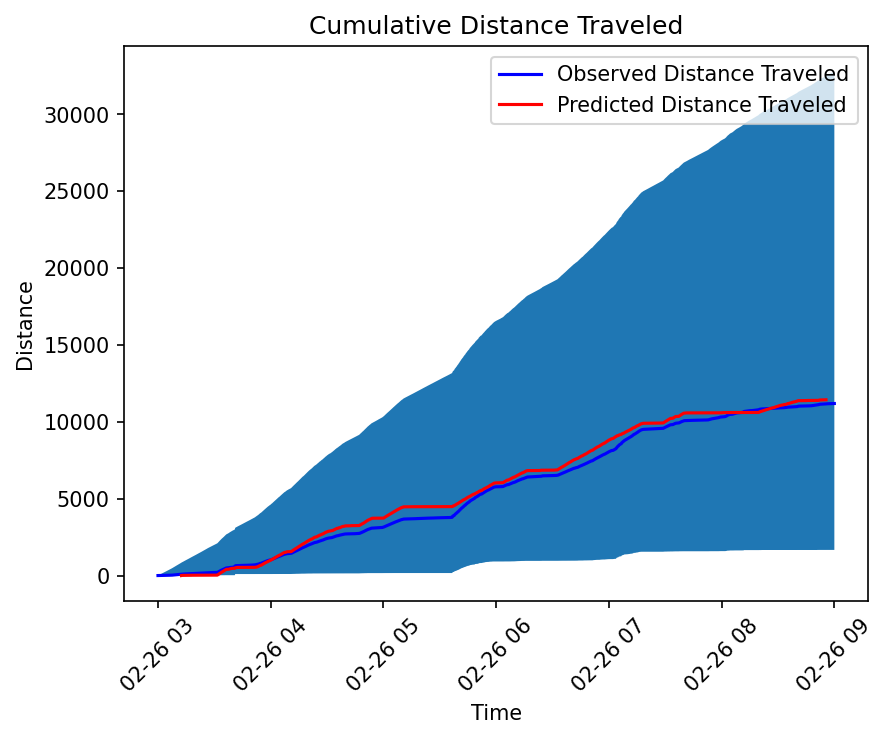

In [35]:
# Plot cumulative distance traveled
obs_dist = gps_pts['cum_dist']
obs_dt = gps_pts['datetime']
pred_dist = step_candidates['cum_dist']
pred_dt = step_candidates['datetime']

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111)

# Plot the trajectory
ax.plot(obs_dt, obs_dist, linestyle='-', color='b', label='Observed Distance Traveled')
ax.plot(pred_dt, pred_dist,linestyle='-', color='r', label='Predicted Distance Traveled')
plt.fill_between(obs_dt, gps_pts['cumsum_lwr'], gps_pts['cumsum_upr'])

# Setting labels
ax.set_xlabel('Time')
ax.set_ylabel('Distance')

# Rotate the x axis labels
plt.xticks(rotation = 45)

# Adding a title and legend
ax.set_title('Cumulative Distance Traveled')
ax.legend()

# Show plot
plt.show()

## Estimate slope
  1) A low-pass butterworth filter can be applied to the pitch so that the resulting signal is a function of the tilt angle of the collar and the slope of the ground 
  2) If the filtered signal is equal to the sum of the slope angle and the collar angle, then slope = filtered signal - collar angle.
  3) Using a differential evolution optimizaion algorithm applied to a loss function, paraemters of a butterworth filter and collar angle  that minimized error between observed and predicted slopes can be obtained. 

In [41]:
# Function to generate model predictions
def model_predictions(params, data):
    # Define parameters
    cutoff_frequency, sampling_rate, collar_angle = params
    # Design the butterworth filter
    order = 4  # 4th order
    nyquist_frequency = 0.5 * sampling_rate
    normalized_cutoff = cutoff_frequency / nyquist_frequency
    b, a = butter(order, normalized_cutoff, btype='low', analog=False)
    data['filtered_pitch'] = filtfilt(b, a, data['pitch'])
    filtered_pitch = data.loc[data['filtered_pitch'].notnull(),'Slope1']
    # Predict slope
    slope =  filtered_pitch - collar_angle
    return slope

# Define the cost and objectie functions
def cost_function(params, data, actual):
    predictions = model_predictions(params, data)
    residuals = actual-abs(predictions)
    return np.sum((residuals)**2)

def objective(params):
    return cost_function(params,data,actual)

# Define perameter bounds for Differential Evolution (a type of genetic algorithm)
bounds = [(0.01,0.1),(1,5),(-0.6,-0.19)] # cutoff frequency, sampling rate, collar angle


In [42]:
# Initialize columns
active_periods['filtered_pitch'] = -999
active_periods['collar_angle'] = -999
active_periods['slope_pred'] = -999

# Find optimal parameters for each activity period and estimate slope

for i in range(0,num_groups):
    # get group number
    group = activity_groups[i]
    
    # get group data
    group_data = active_periods[active_periods['activity_group'] == group]
    data = group_data
    actual = group_data.loc[group_data['Slope1'].notnull(),'Slope1']

    # Run differential evolution aglorithm to estimate optimal parameter values
    result = differential_evolution(objective, bounds)
    
    # DESIGN THE BUTTERWORTH FILTER

    # Parameters
    order = 4  # 4th order
    cutoff_frequency = result.x[0]  # Cutoff frequency in Hz
    sampling_rate =  result.x[1] # Sampling rate in Hz (adjust as needed)
    
    # Normalized cutoff frequency (as a fraction of the Nyquist frequency)
    nyquist_frequency = 0.5 * sampling_rate
    normalized_cutoff = cutoff_frequency / nyquist_frequency
    
    # Get the filter coefficients
    b, a = butter(order, normalized_cutoff, btype='low', analog=False)

    # Create dataset where each row represents step endpoint
    group_data['filtered_pitch'] = filtfilt(b, a, group_data['pitch'])
    group_data['collar_angle'] = result.x[2]
    group_data['slope_pred'] = group_data['filtered_pitch'] - group_data['collar_angle']

    # Join group results back to main results table
    active_periods[active_periods['activity_group']==group] = group_data

    


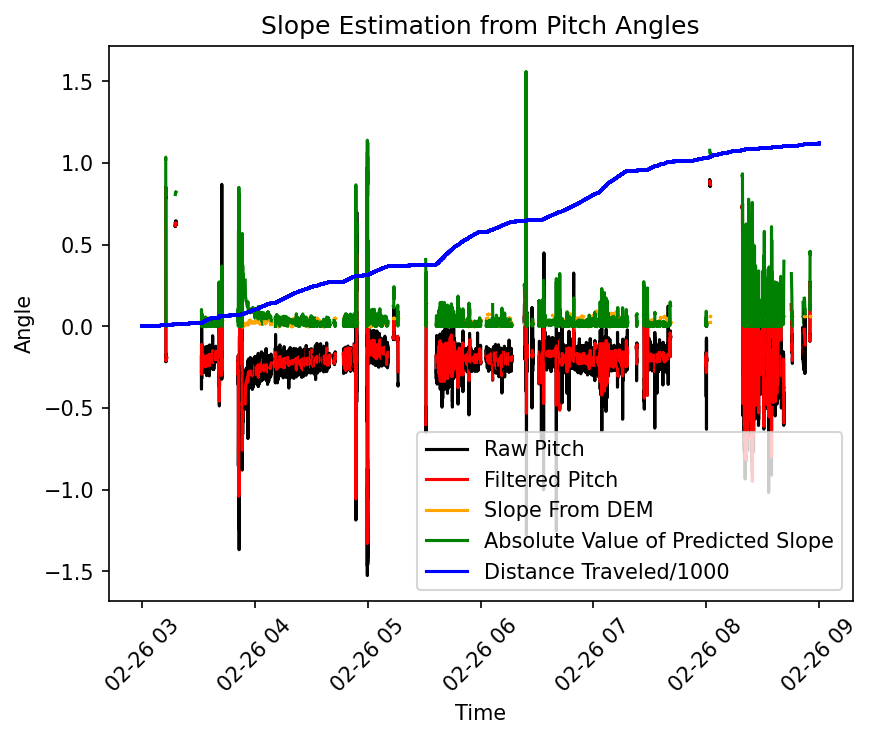

In [43]:
# Create plot
fig = plt.figure()
ax = fig.add_subplot(111)

# Add data by group
for i in range(0,num_groups):

    # get group number
    group = activity_groups[i]
    
    # get group data
    group_data = active_periods[active_periods['activity_group'] == group]
    
    # Get data for plotting
    pitch = group_data['pitch']
    slope_guess = abs(group_data['slope_pred'])
    pitch_filt = group_data['filtered_pitch'] 
    dt = group_data['datetime']
    slope = group_data['Slope1']*math.pi/180

    # Plot the data
    ax.plot(dt, pitch, linestyle='-', color='black', label='Raw Pitch')
    ax.plot(dt, pitch_filt,  linestyle='-', color='red', label='Filtered Pitch')
    ax.plot(dt, slope,  marker = ".", color='orange', label='Slope From DEM', markersize = 1)
    ax.plot(dt, slope_guess,  linestyle='-', color='g', label= 'Absolute Value of Predicted Slope')
    ax.plot(obs_dt, obs_dist/10000, linestyle='-', color='b', label='Distance Traveled/1000')

    # Add legend
    if i == 0:
        ax.legend()



# Rotate the x axis labels
plt.xticks(rotation = 45)

# Setting labels
ax.set_xlabel('Time')
ax.set_ylabel('Angle')

# Adding a title and legend
ax.set_title('Slope Estimation from Pitch Angles')

# Show plot
plt.show()



## Calculate elevation change

In [44]:
# Merge step candidates with active_periods to get distance traveled
active_periods = pd.merge(active_periods, step_candidates[['distance_traveled','datetime']], on='datetime', how='left')
active_periods['distance_traveled'] = active_periods['distance_traveled'].fillna(0)

In [45]:
# Calculate elevation change from acc data

dist = np.array(active_periods['distance_traveled'])
slope = np.array(active_periods['slope_pred'])
active_periods['delta_elev'] = dist * np.tan(slope)
active_periods['cum_delta_elev'] = active_periods['delta_elev'].cumsum()
active_periods


,valid_step,datetime,level_0,index,Acc_x,Acc_y,Acc_z,Mag_x,Mag_y,Mag_z,...,activity_group,active,thresh_z,falling_edges,filtered_pitch,collar_angle,slope_pred,distance_traveled,delta_elev,cum_delta_elev
0,NaN,2019-02-26 03:12:26.000,7460,173028,-0.551758,0.731934,-0.467773,-0.134277,0.145264,-0.189941,...,181,True,-1.014678,False,0.833357,-0.190003,1.023359,0.000000,0.000000,0.000000
1,NaN,2019-02-26 03:12:26.076,7461,173029,-0.563965,0.719971,-0.467773,-0.134277,0.146973,-0.190918,...,181,True,-1.014678,False,0.838405,-0.190003,1.028408,0.000000,0.000000,0.000000
2,NaN,2019-02-26 03:12:26.179,7462,173030,-0.551758,0.719971,-0.479980,-0.132324,0.147705,-0.189941,...,181,True,-1.014678,False,0.842292,-0.190003,1.032294,0.000000,0.000000,0.000000
3,NaN,2019-02-26 03:12:26.282,7463,173031,-0.563965,0.731934,-0.467773,-0.132568,0.142578,-0.189941,...,181,True,-1.014678,True,0.844723,-0.190003,1.034725,0.000000,0.000000,0.000000
4,NaN,2019-02-26 03:12:26.384,7464,173032,-0.539795,0.767822,-0.467773,-0.133545,0.143799,-0.190430,...,181,True,-1.014678,False,0.845399,-0.190003,1.035402,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114347,1,2019-02-26 08:55:31.897,213281,378849,0.179932,0.239990,-0.995850,0.076904,-0.021484,-0.260254,...,2807,True,-1.043957,False,0.254551,-0.190001,0.444552,0.000000,0.000000,-176.840179
114348,1,2019-02-26 08:55:32.000,213282,378850,0.179932,0.263916,-0.995850,0.076904,-0.021729,-0.258057,...,2807,True,-1.043957,False,0.253659,-0.190001,0.443660,0.000000,0.000000,-176.840179
114349,1,2019-02-26 08:55:32.075,213283,378851,0.179932,0.263916,-0.983887,0.076416,-0.023926,-0.256348,...,2807,True,-1.043957,False,0.252758,-0.190001,0.442759,0.000000,0.000000,-176.840179
114350,1,2019-02-26 08:55:32.175,213284,378852,0.167969,0.251953,-0.995850,0.076416,-0.023193,-0.255859,...,2807,True,-1.043957,False,0.251874,-0.190001,0.441875,0.000000,0.000000,-176.840179


In [50]:
# Calcualte elevation change from gps data
dist = np.array(gps_pts['euclidean_distance_step'])
slope = np.array(gps_pts['Slope1'])*math.pi/180
gps_pts['delta_elev'] = dist * np.tan(slope)
gps_pts['delta_elev'] = gps_pts['delta_elev'].fillna(0)
gps_pts['cum_delta_elev'] = gps_pts['delta_elev'].cumsum()
gps

,Date,Time,location.lat,location.long,Height.above.msl,UTM_E,UTM_N,Slope1,datetime_txt,datetime
0,19/02/2019,23:52:04,-26.230715,20.807151,884.0,480737.954829,7.098751e+06,2.122716,19/02/2019 23:52:04,2019-02-19 23:52:04
1,19/02/2019,23:52:05,-26.230715,20.807151,884.0,480737.954829,7.098751e+06,2.122716,19/02/2019 23:52:05,2019-02-19 23:52:05
2,19/02/2019,23:52:06,-26.230715,20.807150,884.0,480737.854947,7.098751e+06,2.122716,19/02/2019 23:52:06,2019-02-19 23:52:06
3,19/02/2019,23:52:07,-26.230715,20.807149,884.0,480737.755066,7.098751e+06,2.122716,19/02/2019 23:52:07,2019-02-19 23:52:07
4,19/02/2019,23:52:08,-26.230714,20.807149,884.0,480737.754901,7.098751e+06,2.122716,19/02/2019 23:52:08,2019-02-19 23:52:08
...,...,...,...,...,...,...,...,...,...,...
1215681,06/03/2019,11:20:55,-26.308222,20.971056,918.0,497110.952658,7.090181e+06,3.463373,06/03/2019 11:20:55,2019-03-06 11:20:55
1215682,06/03/2019,11:20:56,-26.308222,20.971055,918.0,497110.852843,7.090181e+06,3.463373,06/03/2019 11:20:56,2019-03-06 11:20:56
1215683,06/03/2019,11:20:57,-26.308222,20.971055,916.0,497110.852843,7.090181e+06,3.463373,06/03/2019 11:20:57,2019-03-06 11:20:57
1215684,06/03/2019,11:20:58,-26.308222,20.971054,916.0,497110.753027,7.090181e+06,3.463373,06/03/2019 11:20:58,2019-03-06 11:20:58


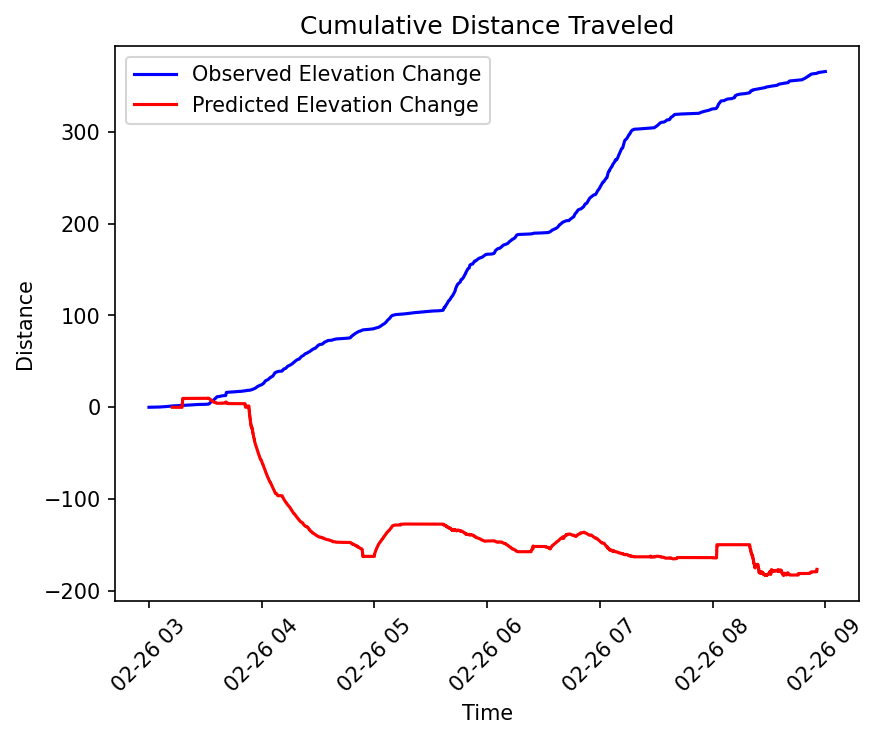

In [51]:
# Plot elevation changes
obs_delta = gps_pts['cum_delta_elev']
obs_dt = gps_pts['datetime']
pred_delta = active_periods['cum_delta_elev']
pred_dt = active_periods['datetime']

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111)

# Plot the trajectory
ax.plot(obs_dt, obs_delta, linestyle='-', color='b', label='Observed Elevation Change')
ax.plot(pred_dt, pred_delta,linestyle='-', color='r', label='Predicted Elevation Change')

# Setting labels
ax.set_xlabel('Time')
ax.set_ylabel('Distance')

# Rotate the x axis labels
plt.xticks(rotation = 45)

# Adding a title and legend
ax.set_title('Cumulative Distance Traveled')
ax.legend()

# Show plot
plt.show()

## Estimate Energy Expenditure
- Energy expenditure can be estimated using the same activation-relaxation cycling model (ARC model) employed by Berti et al. under the ENERSCAPE framework
- According to the ARC model, the energetic cost of transport is a function of distance traveled, slope of the ground, and body mass of the animal. Distance traveled and slope of the ground can be obtained using the algorithm above.

In [48]:
steps = pd.merge(step_candidates, active_periods,on = 'datetime', how='left')

In [49]:
# Set body mass
body_mass = 200

dist = np.array(steps['distance_traveled'].iloc[1:])
slope = np.array(steps['slope_pred'].iloc[0:-1])
term1 = 8 * math.pow(body_mass,-0.34)
term2 = 50 * (1 + np.sin(2*slope-(74*math.pi/180))) * math.pow(body_mass,-0.12)
Ecot = term1 + term2
E = Ecot * body_mass * dist / 4184
steps['energy'] = np.append([0],E)
steps['cum_energy'] = steps['energy'].cumsum()
# def calc_energy(row):
#     global body_mass
#     global prev_slope
#     dist = row['distance_traveled']
#     Ecot = 
#     E = ((8*(body_mass**0.66))+(50*(body_mass**0.88)*(1+math.sin((2*prev_slope)-74))))*dist/4184
#     prev_slope = row['slope_pred']*180/math.pi
#     return E

# steps['energy'] = steps.apply(calc_energy,axis=1)
slope

KeyError: 'distance_traveled'

In [ ]:
steps

In [ ]:
# PLOT CUMULATIVE ENERGY EXPENDITURE

energy = steps['cum_energy']
#energy = steps['distance_traveled']
dt = steps['datetime']

# Create a 3D plot
fig = plt.figure()
ax1 = fig.add_subplot(111)

# Plot the trajectory
ax1.plot(dt, energy, linestyle='-', color='blue', label='Cumulative Energy Expenditure')

# Rotate the x axis labels
plt.xticks(rotation = 45)

# Setting labels
ax1.set_xlabel('Time')
ax1.set_ylabel('calories')

# Adding a title and legend
ax1.set_title('Energy Expended on Locomotion')
ax.legend()

# Show plot
plt.show()

In [ ]:
# plot distance vs energy
E = steps['energy']
dist = steps['distance_traveled']
slope = steps['slope_pred']

plt.scatter(dist,E, c = slope, cmap = "viridis")
plt.colorbar()  
plt.show()


In [ ]:
# plot slope vs energy
plt.scatter(slope,E, c = dist, cmap = "viridis")
plt.colorbar()
plt.show()
